# Прогнозирование спроса на доставку

[Ссылка на отчет](https://www.notion.so/cherkas/fd427070075f4bcab5caa9576cb28007)

[Ссылка на папку с данными и моделями](https://drive.google.com/drive/folders/1j83WAiXT2MUOQmkldDCE8DgIyW7fhLdS?usp=sharing)


## Введение

Choco Доставка - это сервис доставки посылок из магазинов до клиентов. Пример клиентов: Kaspi магазин, Алсер, Europharma, KFC и другие.

У Чоко Доставки есть проблема - дисбаланс заказов и курьеров. При повышенном спросе, у компании больше заказов чем курьеров из-за чего увеличивается время доставки, так как курьеру нужно освободиться, чтобы взять новый заказ. Когда курьеров больше чем заказов, то компания начинает им платить за простой.

Часть команды считает,  что наймом большего количества курьеров можно решить проблему, однако с этим согласны не все. Мы хотим проверить гипотезу, что прогнозирование спроса заказов позволит минимизировать долгое время доставки / простой курьеров.

Допустим,  что распределение заказов Алматы схоже с распределением поездок в Чикаго в Соединенных Штатах. Проведем наше исследование на данных по Чикаго.

Нужные данные, таблицы и датасеты в этой [папке](https://drive.google.com/drive/u/0/folders/1l2ns0oLM4Of6rJSKXNMIIx4Oy9SrSmLi).

### Гипотеза

Прогнозирование спроса заказов позволит оптимизировать работу курьеров и повысит скорость доставки без найма дополнительных курьеров.

### Цель

Повысить эффективность доставки, не нанимая дополнительных курьеров.

### Задачи

1. Провести анализ данных.
2. Преобразовать и обогатить данные для обучения модели.
3. Построить модель прогноза спроса поездок.
4. Протестировать модель.
5. Сохранить модель.
6. Подвести итоги.

## Анализ данных

In [1]:
# импортируем нужные библиотеки для работы с данными
import geopandas as gpd
import missingno as msgn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
# посмотрим на табличные данные
df = pd.read_csv('ride_panel.csv')
df.sample(5)

,Interval_Hourly,GEOID,Trip_Count,Temperature,Percipitation,Wind_Speed,week,dotw
132776,2018-12-02T19:00:00Z,17031060100,0,41.0,0.0001,13,48,Sun
55482,2018-11-16T14:00:00Z,17031310800,5,39.2,0.0000,9,46,Fri
15005,2018-11-08T03:00:00Z,17031070500,0,34.0,0.0000,10,45,Thu
157673,2018-12-08T00:00:00Z,17031062800,13,21.0,0.0000,5,49,Sat
239095,2018-12-25T01:00:00Z,17031080400,0,28.0,0.0000,3,52,Tue


1. ride_panel.csv - панельные данные поездок в Чикаго
    - Interval_Hourly - почасовой интервал
    - GEOID - уникальный идентификатор района Чикаго
    - Trip_Count - кол-во поездок
    - Temperature - температура в Чикаго
    - Percipitation - осадки в Чикаго
    - Wind_Speed - скорость ветра в Чикаго
    - week - порядковый номер неделе
    - dotw - день недели
2. area_tracts_sf - набор shape файлов с географической информацией районов Чикаго
    - GEOID - уникальный идентификатор района Чикаго
    - geometry - geojson района Чикаго

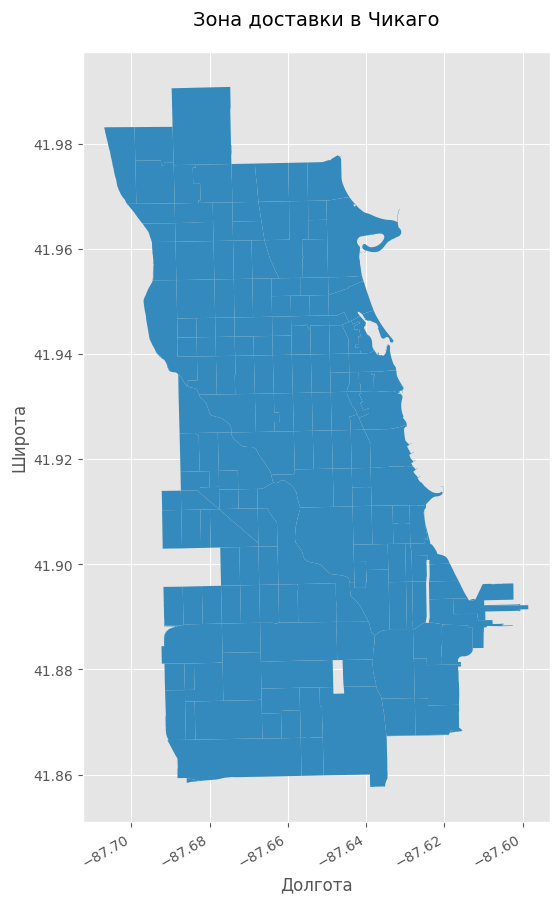

In [24]:
# прочитаем shapefile
chicago_shapefile = gpd.read_file('area_tracts.shp')

# Визуализируем shapefile
fig, ax = plt.subplots(figsize=(10, 10))
chicago_shapefile.plot(ax=ax)
ax.set_title('Зона доставки в Чикаго', fontsize=14, pad=20)
ax.set_xlabel('Долгота')
ax.set_ylabel('Широта')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
fig.savefig('area_tracts.png', dpi=300)
plt.show()

## Преобразование и обогащение данных

In [4]:
# преобразуем данные в столбце Interval_Hourly в datetime формат
df['Interval_Hourly'] = pd.to_datetime(df['Interval_Hourly'])

# создадим столбец, который будет отображать дни недели в числовом формате
df['dotw_num'] = df['Interval_Hourly'].dt.weekday + 1

# создадим столбец, который будет отображать выходной это день недели или нет
df['weekend'] = df['dotw'].apply(lambda x: 1 if x in ['Sat', 'Sun'] else 0)

# создадим столбец, который будет отображать дату
df['Date'] = df['Interval_Hourly'].dt.date

# создадим столбец, который будет отображать час (от 0 до 23)
df['Hour'] = df['Interval_Hourly'].dt.hour

# создадим столбец "Время суток" 
bins = [0, 6, 12, 18, 24]
labels = ['Ночь', 'Утро', 'День', 'Вечер']
df['Time_of_day'] = pd.cut(df['Hour'], bins=bins, labels=labels, include_lowest=True)

# переименуем дни недели для красоты визуализации
day_names = {
    'Mon': 'Понедельник',
    'Tue': 'Вторник',
    'Wed': 'Среда',
    'Thu': 'Четверг',
    'Fri': 'Пятница',
    'Sat': 'Суббота',
    'Sun': 'Воскресенье'
}

df['dotw'] = df['dotw'].replace(day_names)

# создадим столбец, где будет отображен тип дня недели: Будни / Выходные
df['day_type'] = df['dotw'].apply(lambda x:
                                  'Выходные' if x in ['Суббота',
                                                      'Воскресенье'] else 'Будни')

In [5]:
# посмотрим на минимум и максимум поездок по GEOID, типу дня и времени суток
by_GEOID = df.groupby(['GEOID', 'day_type', 'Time_of_day'])['Trip_Count'].median().reset_index()
by_GEOID

,GEOID,day_type,Time_of_day,Trip_Count
0,17031020701,Будни,Ночь,0.0
1,17031020701,Будни,Утро,0.0
2,17031020701,Будни,День,0.0
3,17031020701,Будни,Вечер,0.0
4,17031020701,Выходные,Ночь,0.0
...,...,...,...,...
1587,17031843700,Будни,Вечер,3.0
1588,17031843700,Выходные,Ночь,2.0
1589,17031843700,Выходные,Утро,1.0
1590,17031843700,Выходные,День,2.0


In [6]:
by_GEOID.min()

GEOID          17031020701
day_type             Будни
Time_of_day           Ночь
Trip_Count             0.0
dtype: object

In [7]:
by_GEOID.max()

GEOID          17031843700
day_type          Выходные
Time_of_day          Вечер
Trip_Count           113.0
dtype: object

### Визуализируем спрос на поездки для разных GEOID

- тёмной-зелёный - минимальный спрос,
- светло-зелёный - умеренный спрос,
- жёлтый - высокий спрос,
- оранжевый - очень высокий спрос,
- ярко-красный - максимальный спрос.

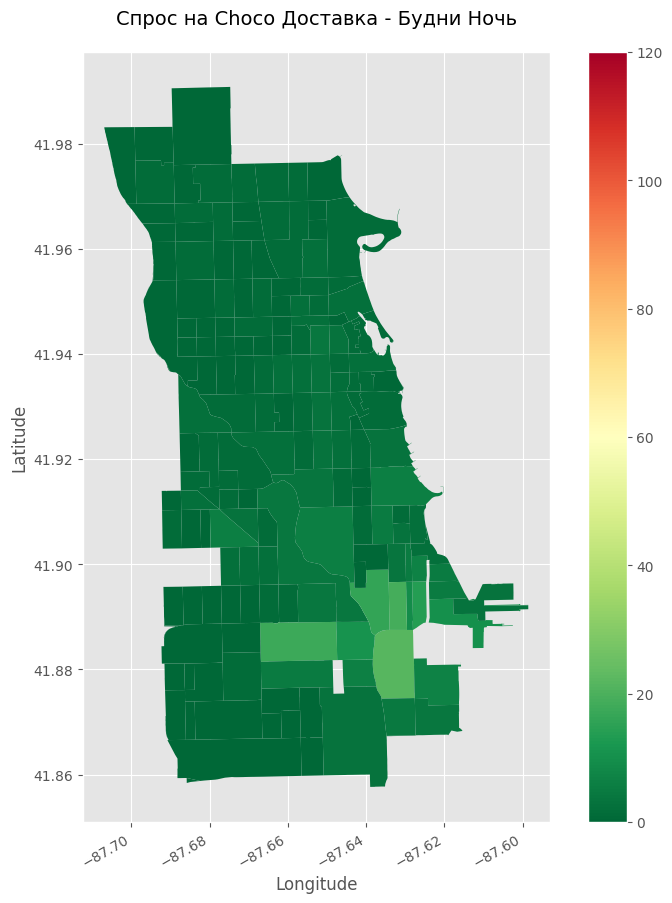

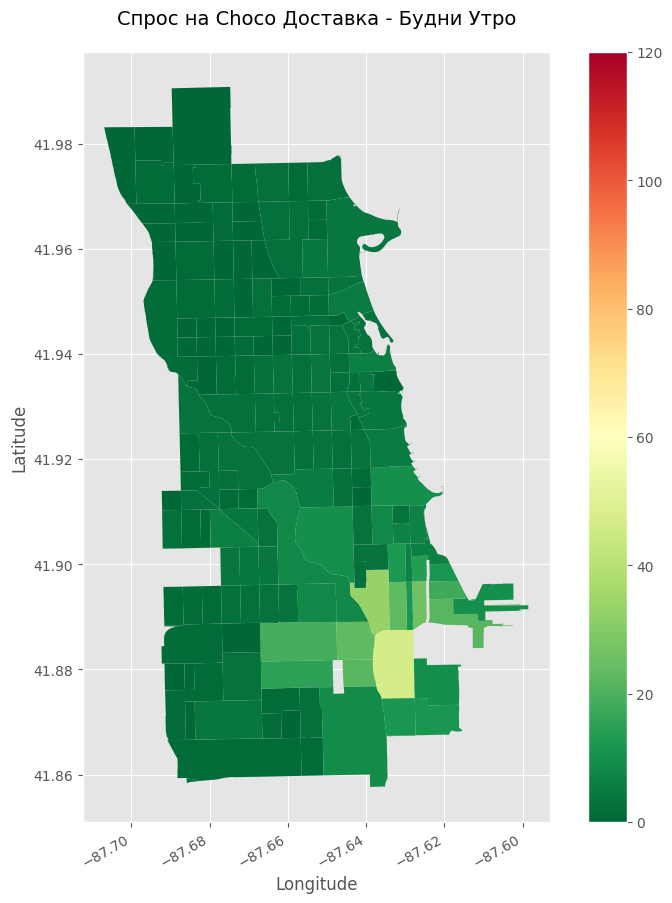

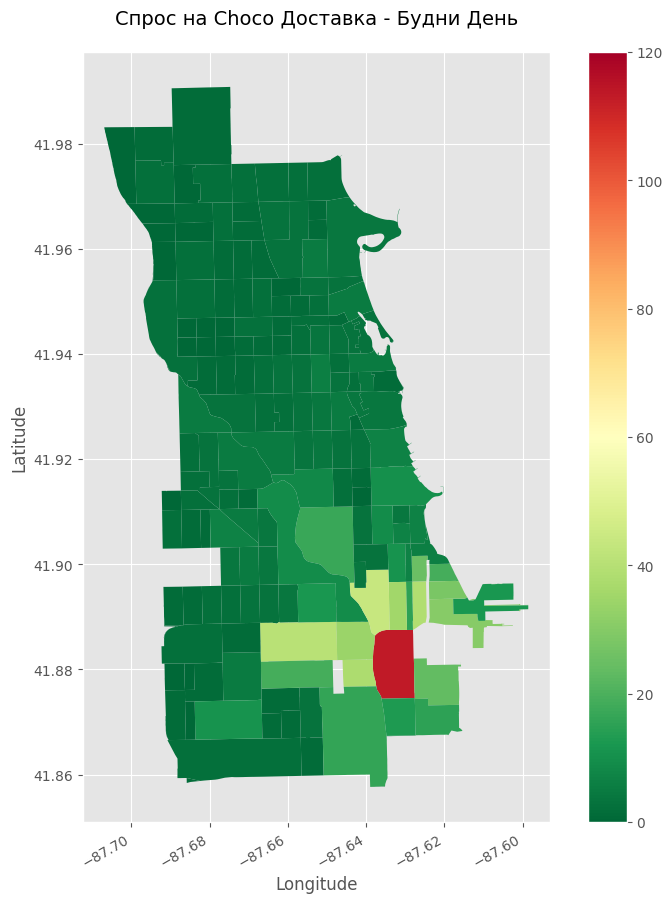

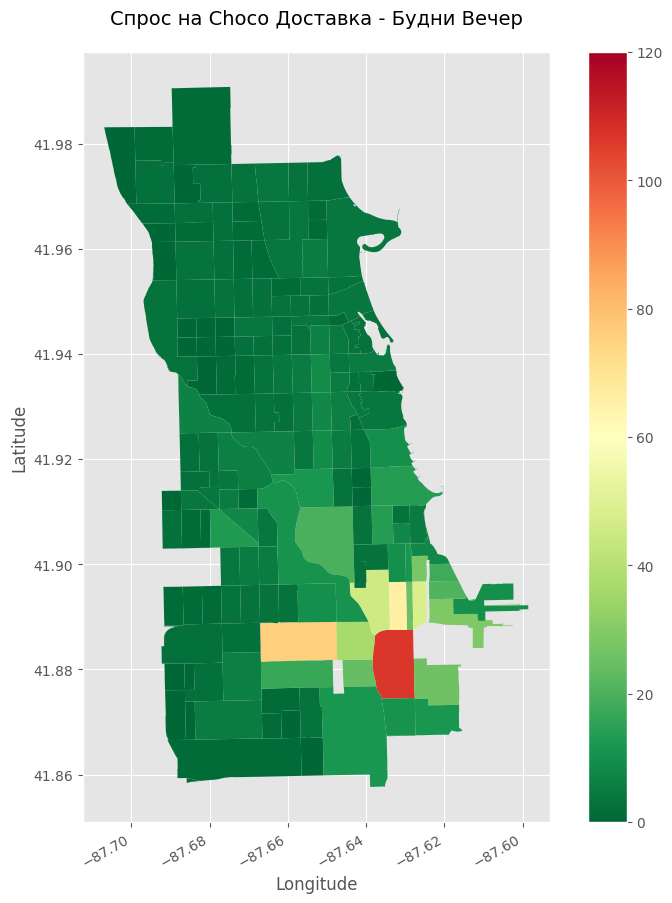

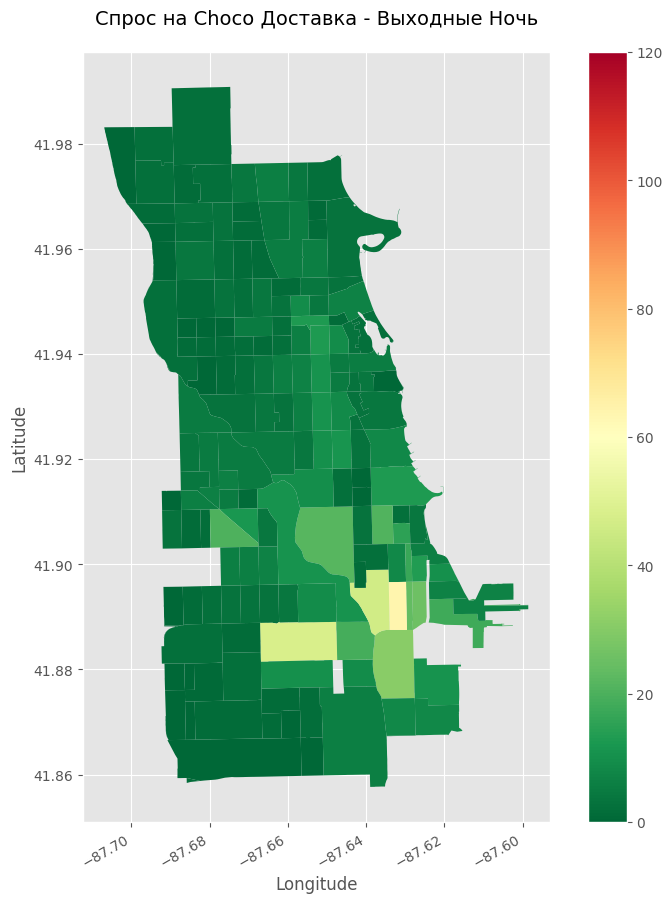

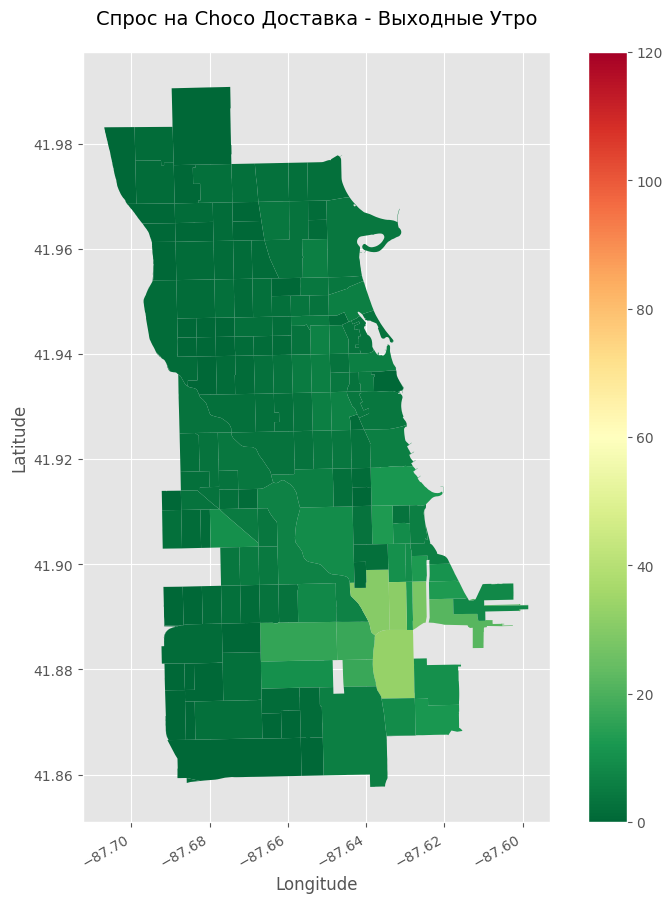

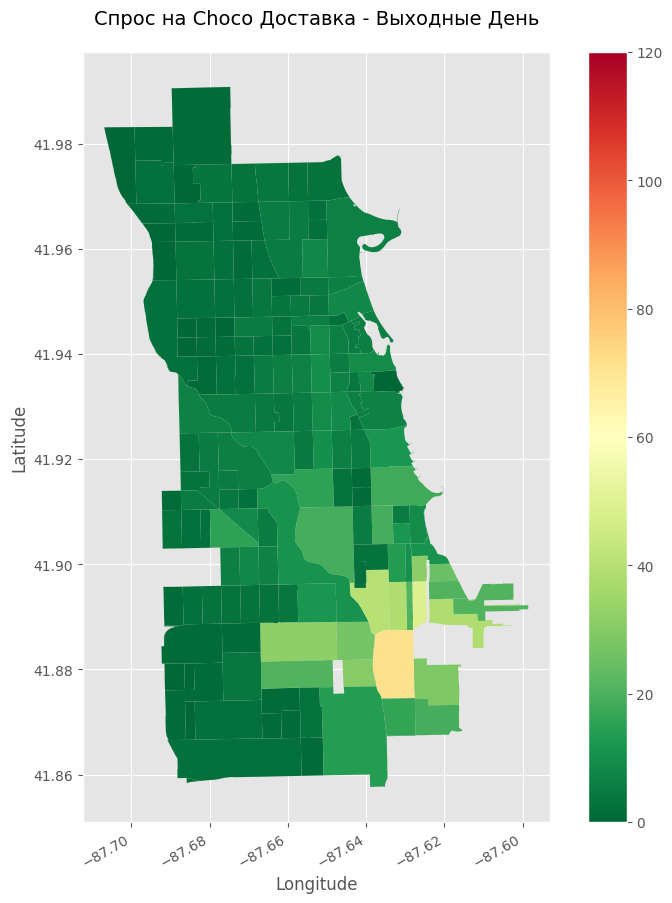

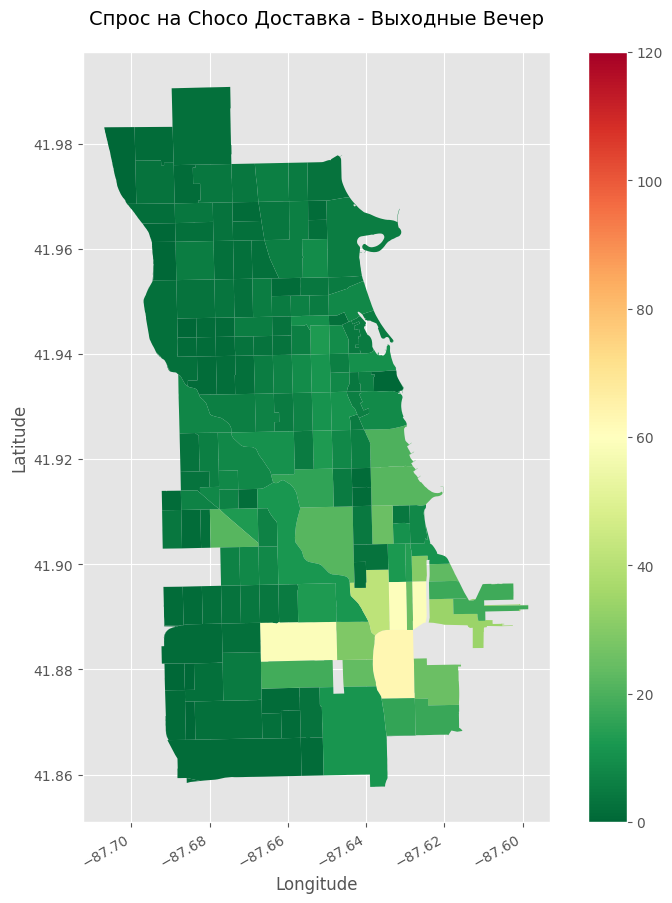

In [25]:
# сделаем визуализацию по такой же группировке
by_day_type = df.groupby(['day_type', 'Time_of_day'])

# создадим карту для каждого времени суток и типа дня недели
for (day, hour), data in by_day_type:
    # сгруппируем данные по GEOID и вычислим медианное значание количество поездок
    geoid_counts = data.groupby('GEOID')['Trip_Count'].median().reset_index()

    # соединим полученные данные с shapefile
    chicago_shapefile['GEOID'] = chicago_shapefile['GEOID'].astype('int64')
    geoid_shapefile = chicago_shapefile.merge(geoid_counts, on='GEOID')
    
    # построим графики с заранее определенными минимумом и максимумом поездок (исходя из максимума в 113, возьмём 120)
    fig, ax = plt.subplots(figsize=(10, 10))
    geoid_shapefile.plot(column='Trip_Count', cmap='RdYlGn_r', ax=ax, legend=True, vmin=0, vmax=120)
    ax.set_title(f'Спрос на Choco Доставка - {day} {hour}', fontsize=14, pad=20)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    
    # сохраним картинки как PNG
    filename = f'{day}_{hour}.png'
    fig.savefig(filename, dpi=300)
    
    plt.show()

### Почасовое количесвто поездок

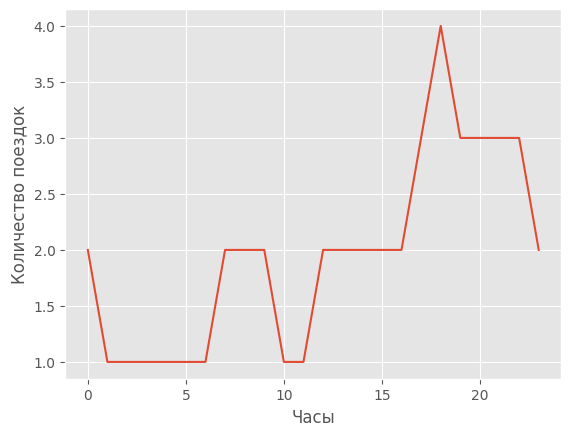

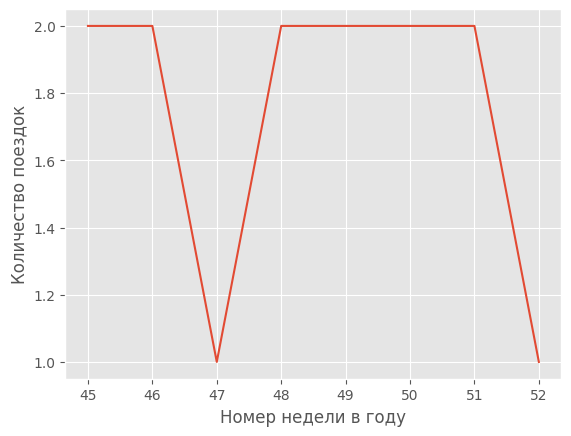

In [9]:
# plot hourly trip count against time of day
plt.plot(df.groupby('Hour')['Trip_Count'].median())
plt.xlabel('Часы')
plt.ylabel('Количество поездок')
plt.show()

# plot hourly trip count against week number
plt.plot(df.groupby('week')['Trip_Count'].median())
plt.xlabel('Номер недели в году')
plt.ylabel('Количество поездок')

plt.show()

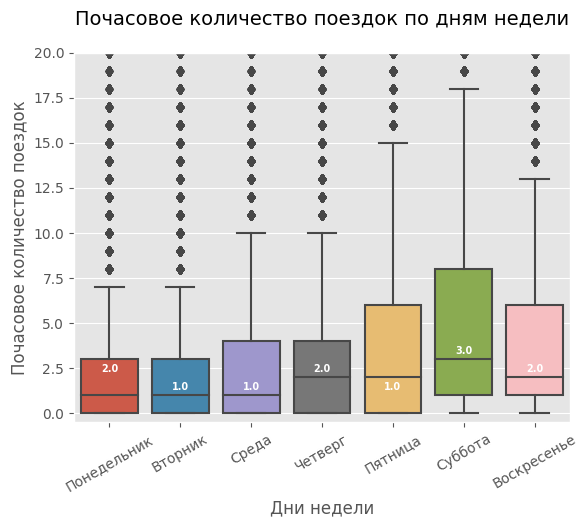

In [26]:
# create the chart
weekday_order = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']

ax = sns.boxplot(data=df, x='dotw', y='Trip_Count', order=weekday_order)
plt.ylabel("Почасовое количество поездок")
plt.xlabel("Дни недели")
plt.xticks(rotation=30)
plt.title("Почасовое количество поездок по дням недели", fontsize=14, pad=20)

# Set the y-axis limits
plt.ylim(-0.5, 20)

# Filter and plot the points above 25
filtered_data = df[df['Trip_Count'] > 20]
plt.plot(filtered_data['dotw'], filtered_data['Trip_Count'], 'o', color='black', alpha=0.5, markersize=3)

# Add a horizontal line for the median value
medians = df.groupby(['dotw'])['Trip_Count'].median().values
median_labels = [str(np.round(s, 2)) for s in medians]

pos = range(len(medians))
for tick, label in zip(pos, ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.3, median_labels[tick],
            horizontalalignment='center', size='x-small', color='w', weight='semibold')
    
fig.savefig('Почасовое количество поездок по дням недели.png', dpi=300)
plt.show()


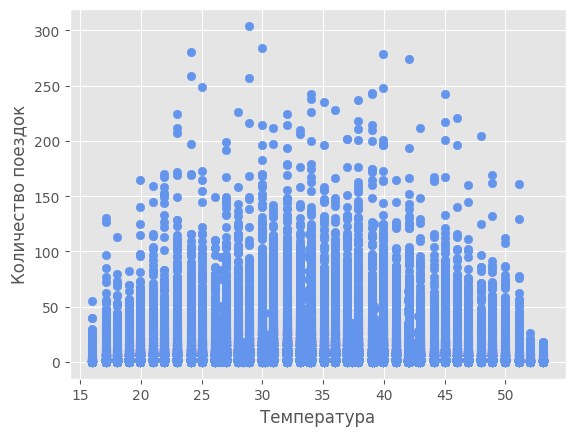

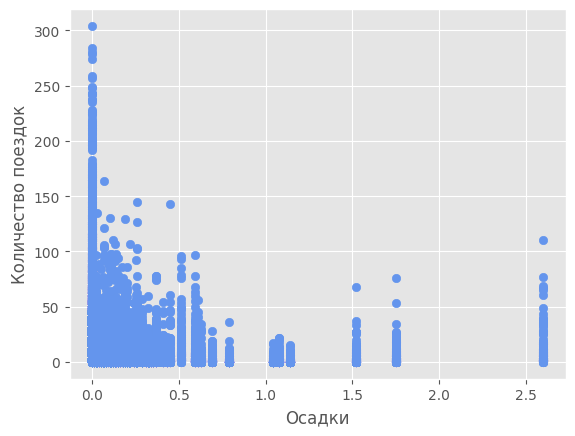

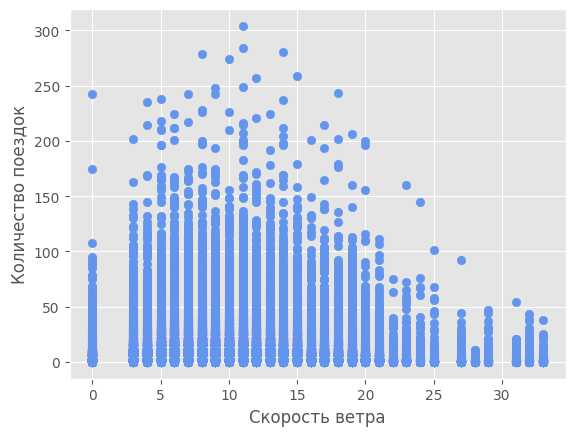

In [11]:
# создадим scatter plot почасового количества поездок в зависимости от температуры
plt.scatter(df['Temperature'], df['Trip_Count'], color='cornflowerblue')
plt.xlabel('Температура')
plt.ylabel('Количество поездок')
plt.show()

# создадим scatter plot почасового количества поездок в зависимости от осадков 
plt.scatter(df['Percipitation'], df['Trip_Count'], color='cornflowerblue')
plt.xlabel('Осадки')
plt.ylabel('Количество поездок')
plt.show()

# создадим scatter plot почасового количества поездок в зависимости от скорости ветра
plt.scatter(df['Wind_Speed'], df['Trip_Count'], color='cornflowerblue')
plt.xlabel('Скорость ветра')
plt.ylabel('Количество поездок')
plt.show()

### Обогащение данных из внешних источников

Данные о точках интереса (POI): получим данные о местоположении и типах POI, таких как торговые центры, рестораны и больницы. Эта информация может помочь определить области с высоким спросом на услуги доставки и оптимизировать работу курьеров.

Получим данные о POI для Чикаго (штат Иллинойс в США), скачав с сайта MyGeodata файл в формате csv: 'poi_point' / 'poi_polygon'.
Далее считайм файл и добавим информацию к нашей таблице.

In [12]:
df_ride_panel = pd.read_csv('poi_point.csv')

# создадим GeoDataFrameна основе df_ride_panel
gdf_ride_panel = gpd.GeoDataFrame(df_ride_panel, geometry=gpd.points_from_xy(df_ride_panel['X'], df_ride_panel['Y']))

# сделаем пространственное соединение
joined_data = gpd.sjoin(gdf_ride_panel, chicago_shapefile, op='within')

joined_data['GEOID'] = joined_data['GEOID'].astype('int64')

merged_df = pd.merge(df, joined_data[['name', 'GEOID']], on=['GEOID'], how='left')

# преобразуем столбец «name» в категориальную переменную
merged_df['name'] = merged_df['name'].astype('category')
merged_df['name_code'] = merged_df['name'].cat.codes

# сгруппируем набор данных по GEOID и подсчитаем количество уникальных кодов имен
grouped = merged_df.groupby('GEOID')['name_code'].nunique()

# создадим новый dataframe с подсчетом уникальных кодов имен для каждого GEOID
df_count = pd.DataFrame({'GEOID': grouped.index, 'count_poi': grouped.values})

# соединим с нашей основной таблицей по GEOID
df = pd.merge(df, df_count, on='GEOID')

In [28]:
# сохраним таблицу
df.to_csv('Данные для модели.csv')

# оставим для обучения только числовые столбцы
df_numeric = df.select_dtypes(include=['number'])

### Тепловая карта корреляционной матрицы
Нас интересуют либо самые светлые ячейки, либо самые тёмные (кроме главной диагонали).  

чем ближе к 1 или -1, тем сильнее корреляция, 0 говорит об отсутствии корреляции.

In [14]:
corr_values = df_numeric.corr()['Trip_Count']
corr_values_sorted = corr_values.sort_values(ascending=False)
print(corr_values_sorted)

Trip_Count       1.000000
count_poi        0.692599
Hour             0.127248
GEOID            0.098455
dotw_num         0.098233
weekend          0.079826
Wind_Speed       0.019138
Temperature      0.018284
Percipitation   -0.001684
week            -0.025855
Name: Trip_Count, dtype: float64


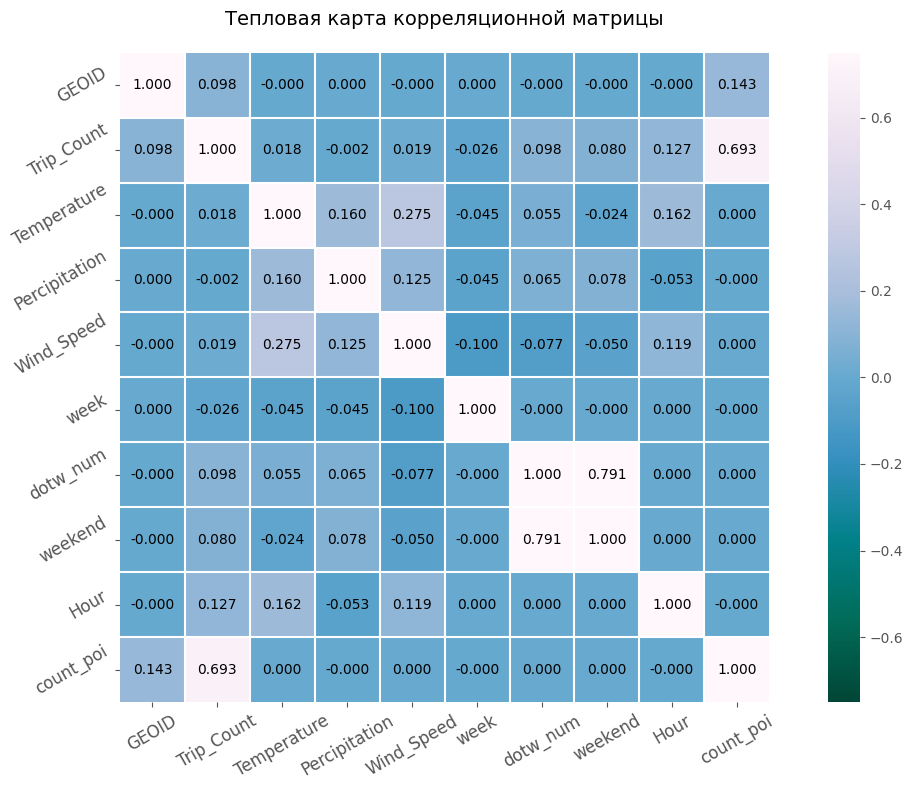

In [15]:
corrmat = df_numeric.corr()

f, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(corrmat, annot=True, annot_kws={"fontsize": 10, "color": "black"},
            fmt='.3f', vmin=-0.75, vmax=0.75, cmap='PuBuGn_r', square=True)
sources = corrmat.columns.get_level_values(0)
for i, source in enumerate(sources):
    if i and source != sources[i - 1]:
        ax.axhline(len(sources) - i, c="w")
        ax.axvline(i, c="w")
ax.set_title('Тепловая карта корреляционной матрицы', fontsize=14, pad=20)
plt.xticks(fontsize=12, rotation=30)
plt.yticks(fontsize=12, rotation=30)
f.tight_layout()

## Построение и тестирование моделей

In [16]:
# загрузим необходимые библиотеки для обучения моделей и тестирования
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [17]:
# Разделим данные на наборы для обучения и тестирования, как рекомендуется в задании
train_data = df_numeric.drop(['weekend'], axis=1).loc[df['week']<50]
test_data = df_numeric.loc[df['week']>=50]

y = train_data['Trip_Count'].values  # целевая переменная
X = train_data.drop(['Trip_Count'], axis=1)

features = X.columns
target = 'Trip_Count'

In [18]:
# конвертируем данные в DMatrix формат для XGBoost
train_dmatrix = xgb.DMatrix(train_data[features], label=train_data[target])
test_dmatrix = xgb.DMatrix(test_data[features], label=test_data[target])

# Установим XGBoost параметры
params = {'objective': 'reg:squarederror', 'eval_metric': 'rmse'}

# обучим XGBoost модель
xgb_model = xgb.train(params, train_dmatrix, num_boost_round=100)

# сделаем прогноз для тестовой выборки
y_pred = xgb_model.predict(test_dmatrix)

# вычислим среднюю абсолютную ошибку (MAE)
mae = mean_absolute_error(test_data[target], y_pred)

# вычислим среднеквадратичную ошибку (RMSE)
rmse = mean_squared_error(test_data[target], y_pred, squared=False)

print("Средняя абсолютная ошибка:", np.round(mae, 4))
print("Среднеквадратичная ошибка:", np.round(rmse, 4))

Средняя абсолютная ошибка: 2.3021
Среднеквадратичная ошибка: 4.769


In [19]:
# обучим CatBoost модель
cat_model = CatBoostRegressor(iterations=100, eval_metric='RMSE', random_seed=42)
cat_model.fit(train_data[features], train_data[target], verbose=False)

# сделаем прогноз для тестовой выборки
y_pred = cat_model.predict(test_data[features])

# вычислим среднюю абсолютную ошибку (MAE)
mae = mean_absolute_error(test_data[target], y_pred)

# вычислим среднеквадратичную ошибку (RMSE)
rmse = mean_squared_error(test_data[target], y_pred, squared=False)

print("Средняя абсолютная ошибка:", np.round(mae, 4))
print("Среднеквадратичная ошибка:", np.round(rmse, 4))

Средняя абсолютная ошибка: 2.3366
Среднеквадратичная ошибка: 4.772


In [20]:
# обучим the random forest модель
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_data[features], train_data[target])

# сделаем прогноз для тестовой выборки
y_pred = rf_model.predict(test_data[features])

# вычислим среднюю абсолютную ошибку (MAE)
mae = mean_absolute_error(test_data[target], y_pred)

# вычислим среднеквадратичную ошибку (RMSE)
rmse = mean_squared_error(test_data[target], y_pred, squared=False)

print("Средняя абсолютная ошибка:", np.round(mae, 4))
print("Среднеквадратичная ошибка:", np.round(rmse, 4))

Средняя абсолютная ошибка: 2.2677
Среднеквадратичная ошибка: 4.8483


## Сохранение моделей

На данном этапе сложно корректно выбрать наиболее эффективную модель из предложенных выше.  Проверка на тестовой выборке не показала существенных различий, однако, как только мы проверим их с помощью большего количества данных, мы сможем объективно оценить их и определить наилучшее соответствие для нашей задачи. Мы также можем провести работу над тонкой настройкой гиперпараметров, добавлением новых функций или удалением ненужных. Эти шаги потенциально могут помочь улучшить производительность моделей и в конечном итоге привести к более точному и надежному результату.

In [21]:
import pickle

# Save the trained CatBoost model to a file
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
    
# Save the trained CatBoost model to a file
with open('catboost_model.pkl', 'wb') as f:
    pickle.dump(cat_model, f)

# Save the trained CatBoost model to a file
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

## Заключение и рекомендации

Проведя глубокий анализ спроса на курьерские поездки в Чикаго, мы получили ценную информацию о факторах, влияющих на спрос на доставку. Наш анализ показал, что спрос сильно зависит от количества точек интереса на геолокацию, дня недели и времени суток. Используя числовые данные GEOID для каждого часа, времени суток и дня недели, мы можем оптимизировать распределение курьеров по геолокации, что поможет повысить эффективность доставки без необходимости нанимать дополнительных курьеров.

В дополнение к этому наш анализ также показал, что геолокация играет решающую роль в определении спроса на поездки. Оптимизируя курьерские поездки на основе геолокации, мы можем лучше удовлетворить потребности клиентов и значительно повысить общую эффективность службы доставки.

Надо отметить, что мы проанализировали данные о поездках всего лишь с 5 ноября по 30 декабря 2018 г.. Мы обнаружили, что погодные условия не оказывают существенного влияния на спрос на поездки, но для окончательных выводов в этом отношении требуется более обширный анализ данных за более длительный период и по большему количеству регионов.

Наконец, мы разработали несколько регрессионных моделей для автоматизации прогнозирования спроса на курьерские поездки. Эти модели были сохранены для дальнейшего дообучения, тестирования и использования. Применяя такие модели, мы можем свести к минимуму простои курьеров и сократить время доставки, что приведет к повышению качества продукции и услуг, повышению лояльности клиентов и непосредственному росту прибыли компании.

В целом, наш анализ и моделирование предоставили комплексную основу для повышения эффективности курьерской доставки, которую можно использовать для предоставления более качественных услуг, повышения удовлетворенности клиентов и, в конечном итоге, стимулирования роста продукта.